<a href="https://colab.research.google.com/github/YUMVOLKOVA/dul_2021/blob/main/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 457 (delta 119), reused 96 (delta 80), pack-reused 242
Receiving objects: 100% (457/457), 73.71 MiB | 24.98 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Checking out files: 100% (68/68), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=37ef50db82b149ec51b34fcb0fc98c335578a96650359a9aec9fd989e24ba557
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [12]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.optim import Adam
import numpy as np
from tqdm.notebook import tqdm

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# немного измененная архитектура с семинара 
class Net(nn.Module):
    def __init__(self, out_dim, hid_dim_full, num_classes):
        super(Net, self).__init__()
        self.out_dim = out_dim
        self.hid_dim_full = hid_dim_full
        self.num_classes = num_classes
        self.half_hid_dim_full = int(self.hid_dim_full // 2)

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, self.hid_dim_full)
        self.fc2 = nn.Linear(self.hid_dim_full, self.half_hid_dim_full)

        self.features = nn.Linear(self.half_hid_dim_full, self.out_dim)
        self.last = nn.Linear(self.out_dim, self.num_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)

In [16]:
class VAT(nn.Module):
  def __init__(self, hidden_dim, ksi, num_classes, alpha):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.ksi = ksi
    self.num_classes = num_classes
    self.alpha = alpha
    self.classifier = Net(self.hidden_dim, self.hidden_dim, self.num_classes)

  def get_loss_without_target(self, data):
    size = data.shape
    with torch.no_grad():
      target_hat = F.log_softmax(self.classifier(data), 1)
    r = F.normalize(torch.randn(size).to(device), dim=(1, 2, 3))
    r = self.ksi * r
    r = r.requires_grad_()

    prob = F.log_softmax(self.classifier(data + r), 1)
    kullback_leibler_divergence_loss = F.kl_div(prob, target_hat, reduction="batchmean")
    
    kullback_leibler_divergence_loss.backward()
    r_norm = F.normalize(r.grad, dim=(1, 2, 3))
    self.classifier.zero_grad()

    p = F.log_softmax(self.classifier(data + r_norm), 1)    
    loss_without_target = F.kl_div(p, target_hat, reduction="batchmean")
    return loss_without_target.mean()

  def get_loss(self, data, target):
    data = data.to(device)
    size = data.shape[0]
    with_target = target != -1
    data_with_target = data[with_target]
    target_hat = self.classifier(data_with_target)

    loss_with_target = F.cross_entropy(target_hat, target[with_target], reduction="none")
    loss_with_target = loss_with_target.mean()

    accuracy_with_target = (torch.argmax(target_hat, 1) == target[with_target]).sum()
        
    loss_without_target = self.get_loss_without_target(data)

    loss = loss_with_target + loss_without_target * self.alpha
    return loss, accuracy_with_target

  def fit(self, train_data, test_data, num_epochs, lr):
    self.train()
    loss_ber_batch, accuracy = [], []
    optimizer = Adam(self.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
      current_accuracy = 0
      count = 0
      for batch, target in train_data:
        batch = batch.to(device)
        size = batch.shape[0]
        target = target.to(device)
        count += (target != -1).sum().item()

        loss, accuracy_with_target = self.get_loss(batch, target)
        current_accuracy += accuracy_with_target  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_ber_batch.append(loss.item())             
      current_accuracy = current_accuracy.item()
      accuracy.append(current_accuracy / count)
    
    loss_ber_batch = np.array(loss_ber_batch)
    accuracy = np.array(accuracy)
    return loss_ber_batch, accuracy




In [17]:
params = {'lr': 5e-4,
          'num_epochs': 15,
          'ksi': 10,
          'batch_size': 256,
          'num_classes': 11,
          'hidden_dim': 128,
          'alpha': 1}

In [21]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train = DataLoader(train_data,
                       batch_size=params['batch_size'],
                       shuffle=True)
    test = DataLoader(test_data,
                       batch_size=params['batch_size'],
                       shuffle=True)
    model_VAT = VAT(hidden_dim=params['hidden_dim'], 
                    ksi=params['ksi'], 
                    num_classes=params['num_classes'],
                    alpha=params['alpha'])
    model_VAT = model_VAT.to(device)
    print('done with init')
    loss_ber_batch, accuracy = model_VAT.fit(train, 
                                             test, 
                                             num_epochs=params['num_epochs'], 
                                             lr=params['lr'])
    print('done with losses and accuracy')
    return loss_ber_batch, accuracy

Files already downloaded and verified
Files already downloaded and verified
done with init


  0%|          | 0/15 [00:00<?, ?it/s]

done with losses and accuracy


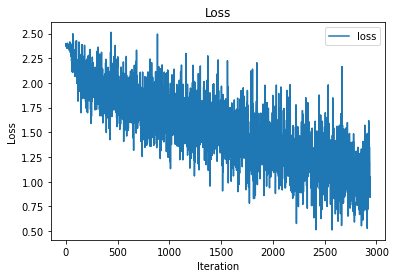

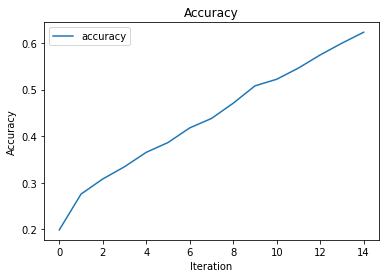

In [22]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """